# Looking at statistics for bits set by Morgan fingerprints

As part of some work I've been doing to add support for the FPB files generated by Andrew Dalke's [chemfp](http://chemfp.com/) package to the RDKit I have been working with the 16 million compounds from the [ZINC "All Clean" set](http://zinc.docking.org/subsets/all-clean). Note that this is from the previous release of ZINC, not the new and exciting ZINC15.

Along the way it occured to me that it would be interesting to look into the properties of the fingerprints across this large set of molecules. That's what this post is about. At the bottom it also takes advantage of the RDKit's depiction code to visualize the bits.

The fingerprints are the RDKit's Morgan fingerprint with radius 2 and 2048 bits and were generated using the latest github version of the RDKit and chemfp to create the FPB file.

# On to the work

## Start with the preliminaries

We need to do a bunch of imports and define some functions we'll use later.

*Note:* This is a Python3 notebook, so the code below may not work in Python2.

In [1]:
import numpy
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
import pickle
from collections import Counter
from rdkit import rdBase
print(rdBase.rdkitVersion)

import time
print(time.asctime())
%pylab inline

2016.03.1.dev1
Wed Feb  3 02:45:43 2016
Populating the interactive namespace from numpy and matplotlib


/home/glandrum/anaconda3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Construct the FPB Reader

In [2]:
reader = DataStructs.FPBReader('/scratch/RDKit_git/Data/Zinc/zinc_all_clean.mfp2.fpb',lazy=True)
reader.Init()
print(len(reader))

16403849


Now loop over all the fingerprints and count both the number of bits set in each fingerprint and the number of times each bit is set. This takes a while.

In [ ]:
numBitCount = Counter()
fpBitCount = Counter()
for i in range(len(reader)):
    fp = reader.GetFP(i)
    numBitCount[fp.GetNumOnBits()]+=1
    for bit in fp.GetOnBits():
        fpBitCount[bit]+=1
    if not i%100000:
        print("Doing: ",i)

Start by looking at the histogram of the number of bits set per molecule

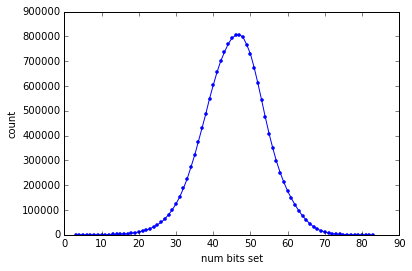

In [4]:
plot([x for x,y in numBitCount.items()],[y for x,y in numBitCount.items()],'.b-')
_=xlabel("num bits set")
_=ylabel("count")

In [14]:
min(numBitCount.items()),max(numBitCount.items())

((3, 17), (83, 2))

The minimum number of bits set is 3, this happens 17 times.
The maximum number of bits set is 83, and this happens only twice.

And the number of times each individual bit is set, but plotted differently so that we can see it:

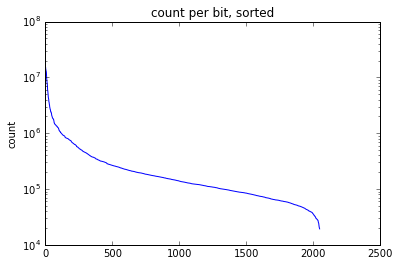

In [5]:
plot(sorted([y for x,y in fpBitCount.items()],reverse=True),'b-')
_=yscale("log")
_=ylabel("count")
_=title("count per bit, sorted")

More detailed stats there:

In [16]:
[np.percentile(sorted([y for x,y in fpBitCount.items()]),z) for z in (1,25,50,75,99)]

[28798.779999999999, 80712.0, 134270.5, 259182.25, 4452384.3499999968]

In [17]:
min([y for x,y in fpBitCount.items()]),max([y for x,y in fpBitCount.items()])

(19300, 15476913)

So the least frequently hit bit is found in 19300 molecules, the most frequently hit is in >15 million

## Find an example molecule for each bit

There's no way to interpret the Morgan fingerprint bits without referring them to the context of a particular molecule that sets the bit. So here we will loop through the molecules until we have one example for each bit:

In [18]:
keepMols={}
toFind = list(set(bitExamples.values()))
bitExamples={}
needed = list(range(reader.GetNumBits()))
suppl = Chem.SmilesMolSupplier('/tmp/zinc_all_clean.smi')
for i,m in enumerate(suppl):
    if not m:
        continue
    
    fp = Chem.GetMorganFingerprintAsBitVect(m,2,2048)
    mid = m.GetProp("_Name")
    for bit in fp.GetOnBits():
        if bit in needed:
            bitExamples[bit] = mid
            keepMols[mid]=m
            needed.remove(bit)
    if not len(needed):
        break
    if not i%10000:
        print("Done:",i," left:",len(needed))


Done: 0  left: 2008


Save everything for later:

In [ ]:
pickle.dump((keepMols,bitExamples,numBitCount,fpBitCount),open("../data/mfp2_analysis.pkl",'wb+'))

Read the results back in:

In [3]:
(keepMols,bitExamples,numBitCount,fpBitCount) = pickle.load(open("../data/mfp2_analysis.pkl",'rb'))

# Now let's look at the most commonly and least commonly set bits

In [8]:
itms = [(y,x) for x,y in fpBitCount.items()]

In [20]:
#
# Functions for providing detailed descriptions of MFP bits from Nadine Schneider 
#  It's probably better to do this using the atomSymbols argument but this does work.
#
def includeRingMembership(s, n):
    r=';R]'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def includeDegree(s, n, d):
    r=';D'+str(d)+']'
    d="]"
    return r.join([d.join(s.split(d)[:n]),d.join(s.split(d)[n:])])
 
def writePropsToSmiles(mol,smi,order):
    #finalsmi = copy.deepcopy(smi)
    finalsmi = smi
    for i,a in enumerate(order):
        atom = mol.GetAtomWithIdx(a)
        if atom.IsInRing():
            finalsmi = includeRingMembership(finalsmi, i+1)
        finalsmi = includeDegree(finalsmi, i+1, atom.GetDegree())
    return finalsmi
 
def getSubstructSmi(mol,atomID,radius):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))
    else:
        atomsToUse = [atomID]
        env=None
    smi = Chem.MolFragmentToSmiles(mol,atomsToUse,bondsToUse=env,allHsExplicit=True, allBondsExplicit=True, rootedAtAtom=atomID)
    order = eval(mol.GetProp("_smilesAtomOutputOrder"))
    smi2 = writePropsToSmiles(mol,smi,order)
    return smi,smi2

Least commonly set bits:

In [10]:
for bCount,bitId in sorted(itms)[:20]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        print(bitId,zid,rad,smi2,bCount)

1767 ZINC00005628 2 [cH;R;D2](:[c;R;D3](:[c;R;D3])-[NH2;D1]):[c;R;D3](:[c;R;D3]):[n;R;D3] 19300
1593 ZINC00000883 2 [cH;R;D2](:[c;R;D3](:[c;R;D3])-[NH;R;D2]):[c;R;D3](:[c;R;D3]):[nH;R;D2] 19948
1579 ZINC00001194 2 [c;R;D3](-[NH;D2]-[C;R;D3])(:[c;R;D3](:[cH;R;D2])-[Cl;D1]):[c;R;D3](:[cH;R;D2])-[Cl;D1] 20071
1672 ZINC00001240 2 [c;R;D3](:[cH;R;D2]:[c;R;D3])(:[c;R;D3](:[cH;R;D2])-[NH;D2]):[c;R;D3](:[cH;R;D2]):[nH+;R;D2] 20326
498 ZINC00000488 2 [cH;R;D2](:[c;R;D3](:[c;R;D3])-[N;R;D3]):[c;R;D3](:[cH;R;D2])-[O;D2] 21344
1558 ZINC00042870 1 [CH;D3](-[C;D3])(-[CH;D3])-[NH2+;D2] 22791
1947 ZINC00001750 1 [c;R;D3](:[c;R;D3])(-[CH;D2]):[s;R;D2] 23547
1732 ZINC00028074 2 [c;R;D3](-[c;R;D3](:[cH;R;D2]):[cH;R;D2])(:[c;R;D3](-[C;D2]):[c;R;D3]):[c;R;D3](:[c;R;D3])-[CH2;R;D2] 24428
1500 ZINC00000507 2 [cH;R;D2](:[c;R;D3](:[c;R;D3])-[CH;D3]):[c;R;D3](:[cH;R;D2])-[O;D2] 24683
346 ZINC00001102 2 [CH;R;D2](-[C;R;D3](-[O;R;D2])=[O;D1])=[C;R;D3](-[CH2;R;D2])-[O;D2] 24987
436 ZINC00003048 2 [c;R;D3](-[OH;D1]

Most commonly set bits:

In [11]:
for bCount,bitId in sorted(itms)[-20:]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        print(bitId,zid,rad,smi2,bCount)

1722 ZINC00000031 1 [CH3;D1]-[c;R;D3] 5100161
1325 ZINC00000056 1 [CH2;R;D2](-[CH;R;D3])-[CH2;R;D2] 5521281
1199 ZINC00000021 2 [cH;R;D2](:[cH;R;D2]:[c;R;D3]):[cH;R;D2]:[cH;R;D2] 5810313
1 ZINC00000022 0 [CH;D3] 5867310
695 ZINC00000017 0 [O;D2] 6461985
875 ZINC00000017 1 [cH;R;D2](:[c;R;D3]):[c;R;D3] 7358623
1019 ZINC00000021 0 [CH;R;D3] 7602601
378 ZINC00000070 0 [n;R;D2] 7995376
935 ZINC00000031 0 [n;R;D3] 8427476
1088 ZINC00000021 1 [cH;R;D2](:[cH;R;D2]):[cH;R;D2] 8880750
1152 ZINC00000017 1 [O;D2](-[C;D3])-[CH3;D1] 9427614
926 ZINC00000021 0 [CH2;R;D2] 9786401
1917 ZINC00000017 1 [O;D1]=[C;D3] 11865273
807 ZINC00000017 0 [C;D3] 12724011
80 ZINC00000017 0 [CH2;D2] 12813180
650 ZINC00000017 0 [O;D1] 13212614
1750 ZINC00000017 1 [cH;R;D2](:[c;R;D3]):[cH;R;D2] 13731476
1057 ZINC00000017 0 [CH3;D1] 13778737
1873 ZINC00000017 0 [cH;R;D2] 15064561
1380 ZINC00000017 0 [c;R;D3] 15476913


## Visualize the results

We can also look at the bits mapped to particular molecules.

The below examples use sample code from my "What's new" presentation at the last UGM (https://github.com/rdkit/UGM_2015/blob/master/Notebooks/Whats_new.ipynb).

In [23]:
# Start by importing some code to allow the depiction to be used:
from IPython.display import SVG
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

# a function to make it a bit easier. This should probably move to somewhere in
# rdkit.Chem.Draw
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc
def moltosvg(mol,molSize=(450,200),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

In [24]:
# do a depiction where the atom environment is highlighted normally and the central atom
# is highlighted in blue
def getSubstructDepiction(mol,atomID,radius,molSize=(450,200)):
    if radius>0:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,radius,atomID)
        atomsToUse=[]
        for b in env:
            atomsToUse.append(mol.GetBondWithIdx(b).GetBeginAtomIdx())
            atomsToUse.append(mol.GetBondWithIdx(b).GetEndAtomIdx())
        atomsToUse = list(set(atomsToUse))       
    else:
        atomsToUse = [atomID]
        env=None
    return moltosvg(mol,molSize=molSize,highlightAtoms=atomsToUse,highlightAtomColors={atomID:(0.3,0.3,1)})
def depictBit(bitId,examples,mols,molSize=(450,200)):
    zid = examples[bitId]
    info={}
    fp = Chem.GetMorganFingerprintAsBitVect(mols[zid],2,2048,bitInfo=info)
    aid,rad = info[bitId][0]
    return getSubstructDepiction(mols[zid],aid,rad,molSize=molSize)

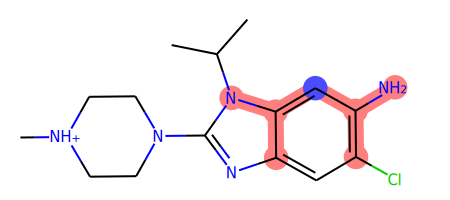

In [11]:
bCount,bitId = sorted(itms)[0]
depictBit(bitId,bitExamples,keepMols)

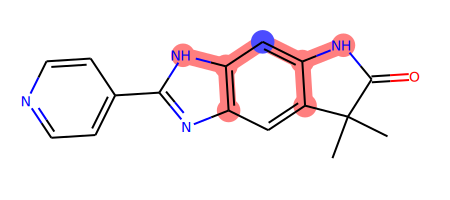

In [12]:
depictBit(sorted(itms)[1][1],bitExamples,keepMols)

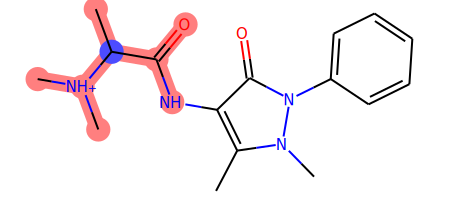

In [13]:
depictBit(sorted(itms)[100][1],bitExamples,keepMols)

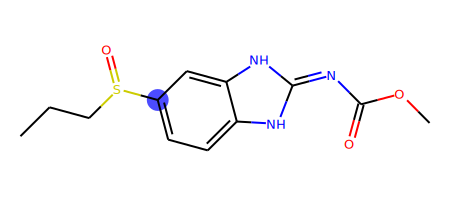

In [14]:
depictBit(sorted(itms)[-1][1],bitExamples,keepMols)

## Use Pandas to visualize those in a table

In [21]:
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

### The least common bits

In [25]:
rows = []
for bCount,bitId in sorted(itms)[:20]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        svg = depictBit(bitId,bitExamples,keepMols,molSize=(250,125))
        rows.append([bitId,zid,svg.data,bCount])


In [26]:
df = pd.DataFrame(rows,columns=('Bit','ZincID','drawing','count'))

In [27]:
df

Bit        ZincID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### the most common bits

In [28]:
rows = []
for bCount,bitId in sorted(itms,reverse=True)[:20]:
    zid = bitExamples[bitId]
    if zid in keepMols:
        info={}
        fp = Chem.GetMorganFingerprintAsBitVect(keepMols[zid],2,2048,bitInfo=info)
        aid,rad = info[bitId][0]
        smi1,smi2 = getSubstructSmi(keepMols[zid],aid,rad)
        svg = depictBit(bitId,bitExamples,keepMols,molSize=(250,125))
        rows.append([bitId,zid,svg.data,bCount])


In [29]:
pd.DataFrame(rows,columns=('Bit','ZincID','drawing','count'))

Bit        ZincID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               